In [1]:
%matplotlib inline

# import packages
import numpy as np
import time
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

import torch
from torch.nn import Linear, LeakyReLU, MSELoss, Sequential
from torch.optim import Adam

from kymatio import Scattering1D


In [2]:
# define plot properties
from cycler import cycler
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(166,206,227), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (9,7.5)
#rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

rcParams['font.size'] = 23


> Calculate scattering coefficients.

In [ ]:
# import packages
from kymatio import Scattering1D
import kymatio

import torch.nn as nn
import torch.optim
import torch
import torch.utils.data as utils

import time
import sys

import numpy as np


#=========================================================================================================
# load light curves
real_spec = np.load("../light_curve.npy")[:10,:]
print(real_spec.shape)

### change the amplitude
#real_spec = real_spec*2.

## mix two modes
#real_spec = (real_spec[:,:] + real_spec[::-1,:])/2.


#================================================================================================
# define wavelet scattering hyperparameters
J = 6
Q = 8
T = real_spec.shape[1]

# convert into torch variable
x = torch.from_numpy(real_spec[:,:T]).type(torch.FloatTensor)
print(x.shape)

# define wavelet scattering
scattering = Scattering1D(J, T, Q)

#================================================================================================
# perform wavelet scattering
Sx_all = scattering.forward(x)

# calculate invariate representation
Sx_all = torch.mean(Sx_all, dim=-1)

# normalize wrt to the first coefficient
for i in range(Sx_all.shape[0]):
    Sx_all[i,:] = Sx_all[i,:]/np.abs(Sx_all[i,0])
    
# take log to normalize the coefficient better
Sx_all = torch.log10(Sx_all[:,1:])
print(Sx_all.shape)

In [ ]:
Sx_all_1 = np.copy(Sx_all)

In [ ]:
Sx_all = Sx_all.numpy()

In [ ]:
print(Sx_all_1[0,:])
plt.plot(Sx_all_1[0,:])
plt.plot(Sx_all[0,:])

> Check wavelet scattering coefficients.

In [ ]:
# load scattering coefficients
Sx = np.load("../Sx_all.npy")
plt.hist(Sx.ravel(), bins=100);

> Sample log probablity.

In [ ]:
# import packages
import numpy as np
from astropy.io import fits
import os

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.autograd import Variable

os.environ['KMP_DUPLICATE_LIB_OK']='True'


#========================================================================================================
# read scattering coefficents
y_tr = np.load("../Sx_all_normal.npy")

# convert into torch
y_tr = torch.from_numpy(y_tr).type(torch.FloatTensor)


#=======================================================================================================
# In [2]:
# define normalizing flow
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp

    def sample(self, z):
        x = self.g(z)
        return x
    
    
#==================================================================================
# restore models
flow = torch.load("../flow_final.pt", map_location=lambda storage, loc: storage) # load in cpu
flow.eval()

#-------------------------------------------------------------------------------------------------------
# sample results
log_prob_x = flow.log_prob(y_tr).detach().numpy()

# save results
np.savez("../real_nvp_results_light_curve_normal.npz",\
         log_prob_x = log_prob_x)


In [ ]:
temp = np.load("../real_nvp_results_light_curve_mixed.npz")
plt.hist(temp["log_prob_x"], bins=50, label="mixed", alpha=0.5, range=[-100,300]);

temp = np.load("../real_nvp_results_light_curve_normal.npz")
plt.hist(temp["log_prob_x"], bins=50, label="normal", alpha=0.5, range=[-100,300]);

plt.legend()

plt.xlabel("log probability")
plt.ylabel("# light curves")

## Gaussian Processes inputation.

> Run with GPy. First a simple example.


In [ ]:
import numpy as np
import GPy

# make mock data
X = np.random.uniform(-3.,3.,(20,1))
Y = np.sin(X) + np.random.randn(20,1)*0.05

# define kernel
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X,Y,kernel)

# optimize
m.optimize(messages=True)
m.optimize_restarts(num_restarts = 10)

# display results
fig = m.plot(plot_density=True)
GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

> Make prediction with the models.

In [ ]:
plt.scatter(X,Y)

X_array = np.linspace(-4,4,100)
X_array = X_array.reshape(X_array.size,1)

Y_predict = np.array(m.predict(X_array))[0,:,:]
plt.plot(X_array,Y_predict)

> Try with real light curve.

In [ ]:
import GPy

# load light curve
temp = np.load("../light_curve.npz")
light_curve = temp["light_curve"]
t_array = temp["t_array"]

# extract a single light cure
X = t_array[0,:]
X = X.reshape(X.size,-1)
Y = light_curve[0,:]
Y = Y.reshape(Y.size,-1)

# define kernel
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X[::10],Y[::10],kernel)

# optimize
m.optimize(messages=True)
m.optimize_restarts(num_restarts = 10)

# display results
fig = m.plot(plot_density=True)
GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

In [ ]:
plt.plot(t_array[0,:],light_curve[0,:], color=cb2[1])

X_array = t_array[0,:]
X_array = X_array.reshape(X_array.size,1)

Y_predict = np.array(m.predict(X_array))[0,:,0]
Y_std = np.sqrt(np.array(m.predict(X_array))[1,:,0])

plt.plot(X_array[:,0],Y_predict, color="black")
plt.fill_between(X_array[:,0], Y_predict-Y_std, Y_predict+Y_std, color=cb2[0])

## SDSS DR14 QSO.

> Read data files.


In [3]:
## all flies
import os
list_files = os.listdir("../qso")

# initiate array
mjd_g = []
g_array = []
mjd_r = []
r_array = []
list_files_store = []

#-------------------------------------------------------------------------------------
# loop over all files
for i in range(len(list_files)):
        
    try:
        # read data
        data = np.loadtxt("../qso/" + list_files[i])
        mjd_g_temp = data[:,2]
        g_temp = data[:,3]
        mjd_r_temp = data[:,0]
        r_temp = data[:,1]
    
        # cull empty entries and sort by time
        choose = mjd_g_temp > 10.
        mjd_g_temp = mjd_g_temp[choose]
        g_temp = g_temp[choose]
        choose = np.argsort(mjd_g_temp)
        mjd_g_temp = mjd_g_temp[choose]
        g_temp = g_temp[choose]
    
        choose = mjd_r_temp > 10.
        mjd_r_temp = mjd_r_temp[choose]
        r_temp = r_temp[choose]
        choose = np.argsort(mjd_r_temp)
        mjd_r_temp = mjd_r_temp[choose]
        r_temp = r_temp[choose]

        # record results
        mjd_g.append(mjd_g_temp)
        g_array.append(g_temp)
        mjd_r.append(mjd_r_temp)
        r_array.append(r_temp)
        list_files_store.append(list_files[i])
        
    except:
        print(i)

# convert to numpy array
mjd_g = np.array(mjd_g)
g_array = np.array(g_array)
mjd_r = np.array(mjd_r)
r_array = np.array(r_array)
list_files = np.array(list_files_store)

#-------------------------------------------------------------------------------------
# save results
np.savez("../SDSS_DR14_qso.npz",\
         mjd_g = mjd_g,\
         g_array = g_array,\
         mjd_r = mjd_r,\
         r_array = r_array,\
         list_files = list_files)


596


> Investigate the time stamp range.

In [ ]:
# time step range
mjd_g_range = np.array([mjd_g[i][-1]-mjd_g[i][0] for i in range(mjd_g.size)])
mjd_r_range = np.array([mjd_r[i][-1]-mjd_r[i][0] for i in range(mjd_g.size)])

plt.hist(mjd_g_range, bins=100, range=[400,500]);
plt.hist(mjd_r_range, bins=100, range=[400,500]);


In [ ]:
# time step recorded
mjd_g_range = np.array([len(mjd_g[i]) for i in range(mjd_g.size)])
mjd_r_range = np.array([len(mjd_r[i]) for i in range(mjd_g.size)])

plt.hist(mjd_g_range, bins=100);
plt.hist(mjd_r_range, bins=100);

#print(np.where(mjd_g_range > 200))

> Try Gaussian Processes on real light curve.

reconstraining parameters GP_regression.sum.Mat32.lengthscale
reconstraining parameters GP_regression.sum.Mat32.variance
reconstraining parameters GP_regression.sum.Mat32_1.lengthscale
reconstraining parameters GP_regression.sum.Mat32_1.variance
reconstraining parameters GP_regression.sum.Mat32_2.lengthscale
reconstraining parameters GP_regression.sum.Mat32_2.variance


lc_753207400024491.dat


Optimization restart 1/10, f = 4231.17920606837
Optimization restart 2/10, f = 4223.089819883555
Optimization restart 3/10, f = 4223.089762910789
Optimization restart 4/10, f = 4223.089840779724
Optimization restart 5/10, f = 4223.08975744946
Optimization restart 6/10, f = 4223.089764940218
Optimization restart 7/10, f = 4223.0897759035415
Optimization restart 8/10, f = 4223.089770253619
Optimization restart 9/10, f = 4223.089783625834
Optimization restart 10/10, f = 4223.089780357969


AttributeError: 'dict' object has no attribute 'figure'

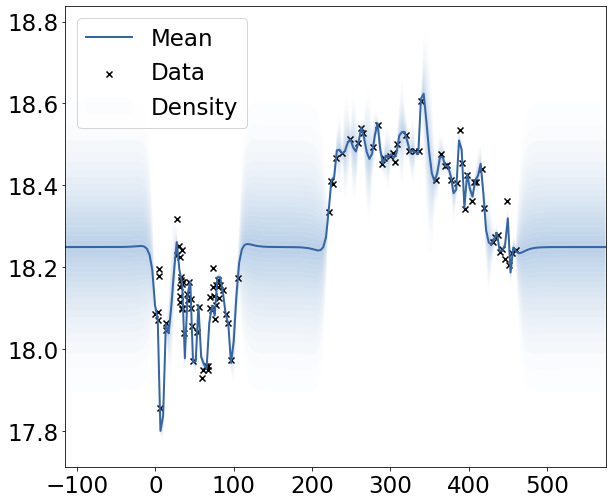

In [4]:
import GPy

#-------------------------------------------------------------------------------------
# choose one object
ind_choose = 100

# extract a single light cure
X = (mjd_g[ind_choose] - mjd_g[ind_choose][0])
X = X.reshape(X.size,-1)
Y = g_array[ind_choose]
Y = Y.reshape(Y.size,-1)

# define kernel
k0 = GPy.kern.Matern32(1) 
k1 = GPy.kern.Matern32(1) 
k2 = GPy.kern.Matern32(1) 

kernel = k0 + k1 + k2 
m = GPy.models.GPRegression(X, Y, kernel, normalizer=True)
#print(m.kern)
print(list_files[ind_choose])

#-------------------------------------------------------------------------------------
# set range parameters
m.kern.Mat32.lengthscale.constrain_bounded(0.1,1)
m.kern.Mat32.variance.constrain_bounded(1e-10,1e-5)

m.kern.Mat32_1.lengthscale.constrain_bounded(1,10)
m.kern.Mat32_1.variance.constrain_bounded(1e-10,1e-5)

m.kern.Mat32_2.lengthscale.constrain_bounded(10,100)
m.kern.Mat32_2.variance.constrain_bounded(1e-10,1.)

# Fix the noise variance to known value 
m.Gaussian_noise.variance = 1e-2**2
m.Gaussian_noise.variance.fix()

# optimize
m.optimize(messages=True)
m.optimize_restarts(num_restarts = 10)
#print(m.kern)

#-------------------------------------------------------------------------------------
# display results
fig = m.plot(plot_density=True)
GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

In [ ]:
# set grid to interpolate into
X_array = np.arange(5120)*0.1
X_array = X_array.reshape(X_array.size,1)

# make prediction
Y_predict = np.array(m.predict(X_array))[0,:,0]
Y_std = np.sqrt(np.array(m.predict(X_array))[1,:,0])

# original data
plt.scatter(X.ravel(), Y.ravel(), color=cb2[1])

# prediction
plt.plot(X_array[:,0],Y_predict, color="black")
plt.fill_between(X_array[:,0], Y_predict-Y_std, Y_predict+Y_std, color=cb2[0], alpha=0.5)

In [5]:
print(-2.5*np.log10(10**(-18.5/2.5)+ 10**(-19/2.5)))

17.96889349301415


> Gaussian Processes in batch.

In [ ]:
# Gaussian Processes package
import GPy
import time
from multiprocessing import Pool
import os
import numpy as np

# set number of threads per CPU
os.environ['OMP_NUM_THREADS']='{:d}'.format(1)

#-------------------------------------------------------------------------------------
# restore grid
temp = np.load("../SDSS_DR14_qso.npz", allow_pickle=True)
mjd_g = temp["mjd_g"]
g_array = temp["g_array"]

# set grid to interpolate into
X_array = np.arange(5120)*0.1
X_array = X_array.reshape(X_array.size,1)

#-------------------------------------------------------------------------------------
# interpolate with GP
def GP_interp(ind_choose):

    # extract a single light cure
    X = (mjd_g[ind_choose] - mjd_g[ind_choose][0])
    X = X.reshape(X.size,-1)
    Y = g_array[ind_choose]
    Y = Y.reshape(Y.size,-1)

    # define kernel
    k0 = GPy.kern.Matern32(1) 
    k1 = GPy.kern.Matern32(1) 
    k2 = GPy.kern.Matern32(1) 
    kernel = k0 + k1 + k2 
    
#-------------------------------------------------------------------------------------
    # define regression
    m = GPy.models.GPRegression(X, Y, kernel, normalizer=True)

    # set range parameters
    m.kern.Mat32.lengthscale.constrain_bounded(0.1,1)
    m.kern.Mat32.variance.constrain_bounded(1e-10,1e-5)

    m.kern.Mat32_1.lengthscale.constrain_bounded(1,10)
    m.kern.Mat32_1.variance.constrain_bounded(1e-10,1e-5)

    m.kern.Mat32_2.lengthscale.constrain_bounded(10,100)
    m.kern.Mat32_2.variance.constrain_bounded(1e-10,1.)

    # fix the noise variance to known value 
    m.Gaussian_noise.variance = 1e-2**2
    m.Gaussian_noise.variance.fix()

#-------------------------------------------------------------------------------------
    # optimize
    m.optimize(messages=True)
    m.optimize_restarts(num_restarts = 10)

    # make prediction
    Y_predict = np.array(m.predict(X_array))[0,:,0]
    
    # return prediction
    return Y_predict


#=====================================================================================
# number of CPU to run in parallel
num_CPU = 4
pool = Pool(num_CPU)
start_time = time.time()
Y_predict_array = np.array(pool.map(GP_interp,range(100)))
print(time.time()-start_time)
    